In [1]:
import requests
import pandas as pd
import json
from datetime import datetime
from datetime import date
from datetime import timedelta
from copy import copy
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
covid_path=os.path.normpath(os.path.join(os.path.abspath(''), '..', '..', 'RKI_COVID19_latest.csv.gz'))
impfmonitoring_paht=os.path.normpath(os.path.join(os.path.abspath(''), '..', '..','Impfquotenmonitoring','raw_data' 'RKI_COVID19_latest.csv.gz'))

In [3]:
today=datetime.now().date()
today_string=today.strftime("%Y-%m-%d")
yesterday=today-timedelta(days=1)

In [4]:
covid_path=os.path.normpath(os.path.join(os.path.abspath(''), '..', '..', 'RKI_COVID19_latest.csv.gz'))
impfmonitoring_path=os.path.normpath(os.path.join(os.path.abspath(''), '..', '..','Impfquotenmonitoring','raw_data', 'RKI_COVID19_Impfquotenmonitoring_'+today_string+'.xlsx'))
print(impfmonitoring_path)

D:\Martin\Python\Github\RKI_COVID19_DATA\Impfquotenmonitoring\raw_data\RKI_COVID19_Impfquotenmonitoring_2021-03-23.xlsx


### Daten einlesen

In [5]:
covid_df=pd.read_csv(covid_path, compression="gzip")

In [51]:
impfung_df=pd.read_excel(impfmonitoring_path,sheet_name="Impfungen_proTag",skipfooter=7)
impfung_df=impfung_df.dropna()

#### Daten aufbereiten

In [7]:
covid_df["Meldedatum"]=pd.to_datetime(covid_df["Meldedatum"]).dt.date
covid_df["Refdatum"]=pd.to_datetime(covid_df["Refdatum"]).dt.date

In [52]:
impfung_df.dropna()
impfung_df["Datum"]=pd.to_datetime(impfung_df["Datum"]).dt.date

#### 7-Tage Inzidenz für Landkreis ERH

In [8]:
erh_df=covid_df[(covid_df["IdLandkreis"]==9572)]
erh_sum=erh_df[erh_df["NeuerFall"].isin([0,1,-1])].groupby("Meldedatum").agg({"AnzahlFall":"sum","Landkreis":"first"}).sort_values("Meldedatum",ascending=False)

count=0
sieben_tage=[]
stichtage=[]
for key, value in erh_sum.iterrows():
    count_current=0
    for i in range(0,7):
        date_current=key-timedelta(days=i)
        if date_current in erh_sum.index:
            count_current+=erh_sum.loc[date_current]["AnzahlFall"]     
    sieben_tage.append(count_current/1.372)
    stichtage.append(key+timedelta(days=1))
    count+=1
    if count>len(erh_sum)-7:
        break

sieben_tage=np.array(sieben_tage)
stichtage=np.array(stichtage)
for i in range(10):
    print(f"{stichtage[i]} --- {sieben_tage[i]:10.2f}")

2021-03-23 ---     105.69
2021-03-22 ---     112.24
2021-03-21 ---     107.14
2021-03-20 ---     112.24
2021-03-19 ---     104.96
2021-03-18 ---     105.69
2021-03-17 ---     104.96
2021-03-16 ---      91.11
2021-03-15 ---      85.28
2021-03-14 ---      83.82


### Plots

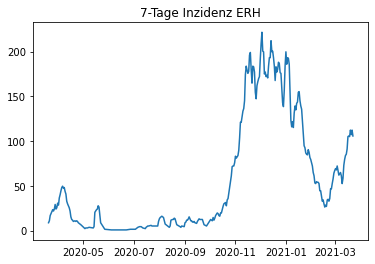

In [9]:
%matplotlib inline
plt.plot(stichtage, sieben_tage)
plt.title("7-Tage Inzidenz ERH")
plt.show()

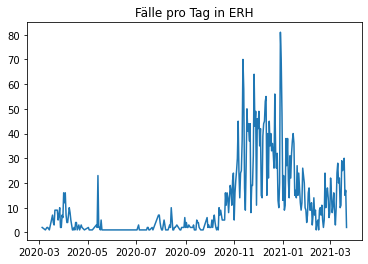

In [64]:
figure2=plt.plot(erh_sum.index,erh_sum.AnzahlFall)
plt.title("Fälle pro Tag in ERH")
plt.savefig('test.png')
plt.show()

### Darstellung Deutschland

#### Bildung von kumulierten Summen

In [16]:
covid_sum=covid_df.groupby("Refdatum").agg({"AnzahlFall":"sum"}).sort_values("Refdatum",ascending=True)
covid_sum['Cum_sum']=covid_sum["AnzahlFall"].cumsum()

#### Bildung von kumulierten Summen der Impfungen

In [56]:
impfung_df['Cum_sum_1']=impfung_df["Erstimpfung"].cumsum()
impfung_df['Cum_sum_2']=impfung_df["Zweitimpfung"].cumsum()
impfung_df['Cum_sum_gesamt']=impfung_df["Gesamtzahl verabreichter Impfstoffdosen"].cumsum()

### Plot sum impfung + erkrankt

In [57]:
covid_sum_impfung=covid_sum[covid_sum.index.isin(impfung_df["Datum"])]

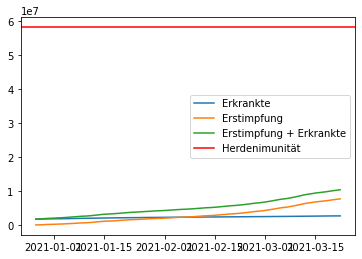

In [62]:
plt.plot(covid_sum_impfung.index,covid_sum_impfung["Cum_sum"], label="Erkrankte")
plt.plot(impfung_df["Datum"],impfung_df["Cum_sum_1"], label="Erstimpfung")
plt.plot(impfung_df["Datum"],impfung_df["Cum_sum_1"].to_numpy()+covid_sum_impfung["Cum_sum"].to_numpy(), label = "Erstimpfung + Erkrankte")
plt.axhline(y=83020000*0.7, color='r', linestyle='-', label="Herdenimunität")
plt.legend()
plt.show()